# 二、如何构造极化码？

## 1. 理论 v.s. 实践

> 依照学界惯用术语，极化码（Polar Codes）并不是某一特定码的名称，而是一类遵循相同理论与设计思想的码的总称。

**极化码的理论共性**：
- 基本性质：线性陪集码（Linear Coset Codes）
- 理论基础：信道极化现象（Channel Polarization）
- 码字生成：指定了一个特定极化码的冻结位（Frozen Bits），和指定了这个特定极化码中各个不同码字的信息位（Information Bits）

**为什么要构造极化码**：

极化码的最优性针对的是这一类码而言，并非对某一个码而言的，更直观地讲，是对任意一个满足信道编码定理的配置而言，在极化码这一类码中，总存在一个满足该配置要求的码。这个码是一定存在的，但问题和Shannon的随机编码一样：我们该怎么找到它呢。幸运的是，找到一个可用的极化码比找到一个可用的随机码要容易得多。

此外，在实际场景下，不论什么码，译码错误概率总不会是严格的$0$。一般来讲，码长越长、码率越低的极化码纠错能力越强，但过长的码长会带来巨大的计算复杂度，而过低的码率则会带来较差的信息承载能力。因此，在使用前，应当依据具体应用需求，权衡冻结位和信息位的选取，从而获得一个合适的极化码。

---

## 2. 构造算法

**目的**：确定各个极化信道的可靠度。

**已有方案**：
1. Monte Carlo 法：通过大量仿真，估计各极化信道的判决错误率；
2. 密度演化算法（Density Evolution）：基于LDPC的阈值分析理论，分析极化码各比特位的判决错误率；
3. 高斯近似（Gaussian Approximation）：对密度演化中的消息分布进行高斯建模，简化计算；
4. 信道退化（Channel Degradation）：构造退化信道序列估计可靠度；
5. 一些启发式算法，如极化权重算法（Polarization Weight）、遗传算法等，兼顾性能与复杂度。

**直观体会**：

我们考虑一个比特翻转概率为$0.11$的简单信道，使用BEC构造法构造出一系列不同码率的极化码，然后分别测试它们的译码错误率：

信道容量0.50[bit]


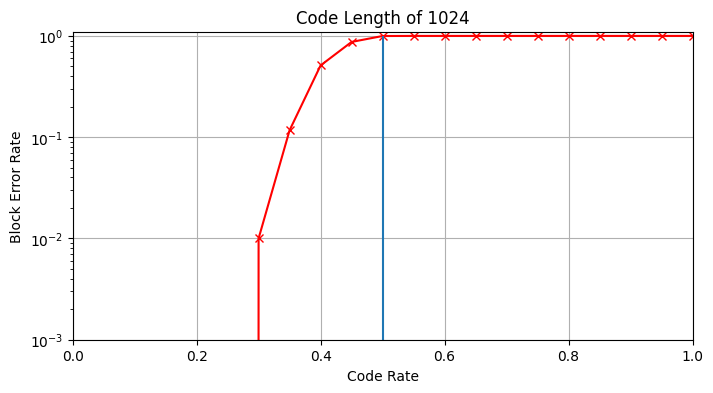

In [3]:
import plcoding
# 比特翻转概率
flip_prob = 0.11
# 信道容量=1-噪声熵
channel_cap = 1 - plcoding.h2_of(flip_prob)
print(f"信道容量{channel_cap:.2f}[bit]")
%run ./codes/bler_rate.py

在码长有限的实际场景下，并不是只要编码码率低于信道容量，就可以实现无错误通信。事实上，从上图不难看出，短码长下极化码的性能还是很差的。虽然这一定程度上跟我们所采用了非最优的BEC算法有关，但即便采用最优构造法，性能也不会好太多。

一般来讲，我们会先选择一组合适的参数，构造一个相应的极化码，然后把它应用到各种不同的场景下，观察其在不同场景下的性能表现，再以此为基础进行进一步微调。不过如果是做理论研究，可能需要更关注极化码的内禀性质，而不会过多关注某一组具体的参数。

---

## 3. BEC构造法

> 二进制擦除信道（Binary Erasure Channels, BEC）

**算法特点**：
1. 理论依据直观；
2. 编程实现简单；
3. 在简单场景下具备足够良好的性能。

**BEC构造法的具体实现**：

- 给定一个实数$e \in (0, 1)$，我们根据它计算得到两个新的值$2e - e^2$和$e^2$，也即$(e) \to (2e - e^2, e^2)$；
- 分别对这两个新的值，继续执行上述操作：记$\alpha = 2e - e^2, \beta = e^2$，那么有$(\alpha, \beta) \to (2\alpha - \alpha^2, \alpha^2,2\beta - \beta^2,  \beta^2)$

依照上述过程，对码长为$N=2^n$的极化码而言，应当重复$n$次，最终会得到长度为$N$的序列，它们表示$N$个极化信道的擦除率。接下来将这些擦除率取负号再加一，即可得到对应的**可靠度序列**。这个过程很容易通过代码实现：

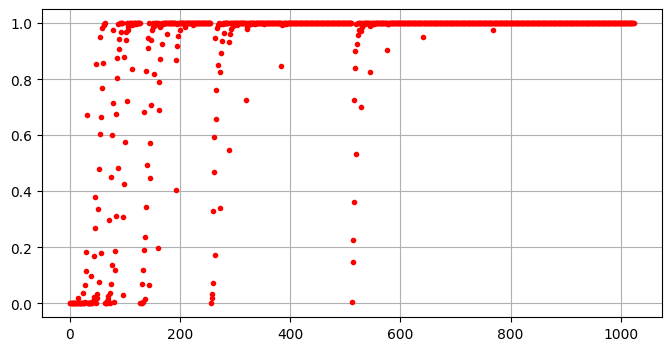

In [3]:
# 初始化几个关键值
e, n = 0.1, 10
# 迭代执行上述过程
old_list = [e]
for _ in range(n):
    new_list = []
    for element in old_list:
        a = 2 * element - element ** 2  # 2e-e^2
        b = element ** 2                # e^2
        new_list.extend([a, b])
    old_list = new_list
for i in range(len(old_list)):
    old_list[i] = 1 - old_list[i]
# 简单绘制一下
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(old_list, 'r.')
plt.grid(); plt.show()